In [1]:
import multiprocessing
from functools import reduce
import operator
import random

import numpy as np
import matplotlib.pyplot as plt
from neuron import h

%load_ext autoreload
%autoreload 2

from GrC import GrC
from Golgi import Golgi

In [5]:
# Instantiation of the cell templates
golgi_cells = [[Golgi(i, morpho) for i in range(count)] for morpho, count in (
    (1, 3),  # 3 of morpho 1
    (2, 2),  # 2 of morpho 2
)]
golgi_cells = reduce(operator.concat, golgi_cells)

grc_cells = [[GrC(i, subtype) for i in range(count)] for subtype, count in (
    ("regular", 2),
    ("mild", 3),
    ("adapting", 4),
    ("accelerate", 1),
)]
grc_cells = reduce(operator.concat, grc_cells)

#mossy_cells = [Mossy(1), Mossy(2), Mossy(3), Mossy(4)]



5394 lines read


ValueError: argument not a density mechanism name.

In [6]:
grc_cells, golgi_cells
#mossy_cells

NameError: name 'grc_cells' is not defined

In [3]:
len(grc_cells[0].HD_pf[1])

NameError: name 'grc_cells' is not defined

In [5]:
ncs = []
h.dt = 0.025
h.celsius = 32
h.tstop = 5000  # TODO: 1700 for accelerating
h.v_init = -70

def create_iclamp(section, loc=0.5, amp=0.01, delay=100, duration=1500):
    ic = h.IClamp(loc, sec=section)
    ic.delay = delay
    ic.dur = duration
    ic.amp = amp
    return ic

# for j, mossy_cell in enumerate(mossy_cells):
#    stims =  [create_iclamp(mossy_cell).soma[0], amp=0.01, delay=100),
#              create_iclamp(mossy_cell.soma[0], amp=0.016, delay=1700),  # TODO: only the first one for accelerating
#              create_iclamp(mossy_cell.soma[0], amp=0.022, delay=3300)]

for j, golgi_cell in enumerate(golgi_cells):
    stims = [create_iclamp(grc_cell.soma[0], amp=0.01, delay=100),
             create_iclamp(grc_cell.soma[0], amp=0.016, delay=1700),  # TODO: only the first one for accelerating
             create_iclamp(grc_cell.soma[0], amp=0.022, delay=3300)]

    # number of AMPA syn, NMDA syn, dend number from 0 to 3

    # Create the synapses (max used in the paper: 89, 20, 20)
    # Not included: inhibitory synapses (up to 20 in the paper)

    # 1 Parallel Fiber reaches 8 Golgi cells, each one synapses ~3 times onto a Golgi cell, 400 Parallel Fibers connect to a single Golgi cell

    # 1 Ascending Axon reaches 23 Golgi cells, each one synapses ~X times onto a Golgi cell  # TODO: get X
    golgi_cell.createsyn(pf_n=len(grc_cells)*3,
                         mf_n=0,
                         aa_n=0)

    # Parallel Fiber Connections
    for i, grc_cell in enumerate(grc_cells):
        pf_i = random.randrange(0, len(grc_cell.HD_pf))
        pf = grc_cell.HD_pf[pf_i]
        sections = [pf[random.randrange(len(pf))] for _ in golgi_cell.L_PF]
        ncs.extend(h.NetCon(sec(0.5)._ref_v, syn.input, 0, 0.1, 1, sec=sec)
                   for syn, sec in zip(golgi_cell.L_PF, sections))


In [6]:
# Fixed time step only
fixed_step = h.CVode()
fixed_step.active(0)

# Activate the multisplit to use half of cores available
cpu = multiprocessing.cpu_count()//2
h.load_file("parcom.hoc")
p = h.ParallelComputeTool()
p.change_nthread(cpu,1)
p.multisplit(1)

0.0

In [7]:
# Basic properties of the simulation
h.dt = 0.025    # change in time between steps (ms)
h.celsius = 32  # temperature of the neurons (*C)
h.v_init = -65  # initial membrane potential (mV)

h.tstop = 1000  # time to stop the entire simulation (ms)
time = h.Vector()
time.record(h._ref_t)
h.finitialize()
h.run()

0.0

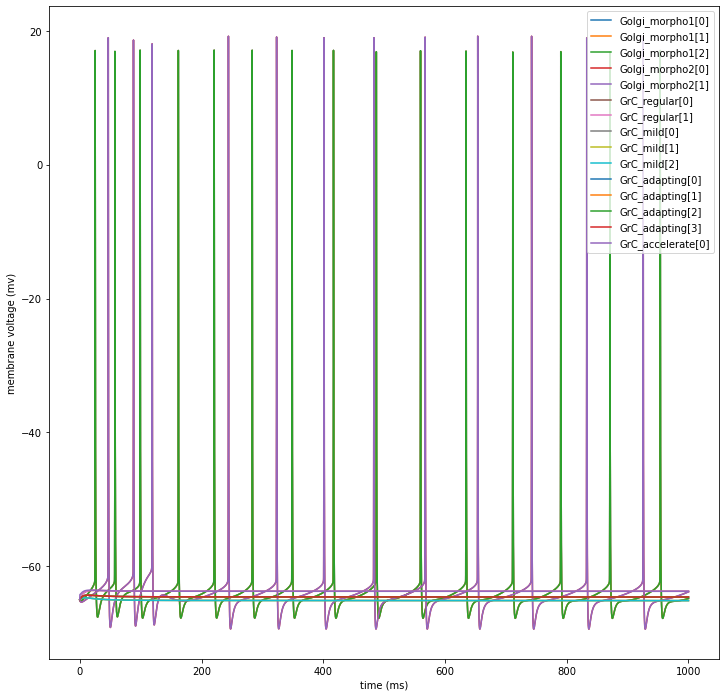

In [10]:
for j, golgi_cell in enumerate(golgi_cells):
    plt.plot(time, np.array(golgi_cell[j].vm), label=str(golgi_cell[j]))
    plt.figure(figsize=(12, 12))
    time = np.array(time)
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")
    plt.legend()

In [ ]:
for j, grc_cell in enumerate(grc_cells):
    plt.plot(time, np.array(grc_cell[j].vm_soma), label=str(grc_cell[j]))
    plt.figure(figsize=(12, 12))
    time = np.array(time)
    plt.xlabel("time (ms)")
    plt.ylabel("membrane voltage (mv)")
    plt.legend()